In [28]:
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from sentinelsat import SentinelAPI, make_path_filter
from IPython import display
import shapely
import os
from PIL import Image

# Load water company data as wrz, remove unnecessary columns
wrz = gpd.read_file(os.path.abspath('data_files/WaterSupplyAreas_incNAVs v1_4.shp'))
    
# select water company to review in further detail:
selected_company_gdf = wrz[wrz['AreaServed'] == 'Bournemouth']

# get the outline of the selected water company:
company_outline = selected_company_gdf['geometry']

# create a new GeoDataFrame with the outline of the selected water company:
outline_gdf = gpd.GeoDataFrame(geometry=company_outline)

# print the GeoDataFrame
print(outline_gdf)

# ensure that the crs for the the gdf of the water company selected is set to epsg 4326
outline_gdf = outline_gdf.to_crs(epsg=4326)

# convert the MULTIPOLYGON to a valid POLYGON
polygon = outline_gdf['geometry'].unary_union
#polygon # to visualise polygon

# get the minimum rotated angle 
search_area = polygon.minimum_rotated_rectangle

#search_area # to visual rotated rectangle



                                             geometry
24  MULTIPOLYGON (((405930.719 89146.440, 405913.6...


In [29]:
#connect to SentinelAPI
api = SentinelAPI(None, None, api_url='https://scihub.copernicus.eu/dhus') # connect to the SentinelAPi using sign on details on .netrc file

#retrieve images for 10% cloud cover, date range 1 April 2019 to 31 March 2020 
products = api.query(search_area.wkt, # use the WKT representation of our search area
                     date=('20230101','20230301'), # all images from February 2023
                     platformname='Sentinel-2', # the platform name is Sentinel-2
                     producttype='S2MSI2A', # surface reflectance product (L2A)
                     cloudcoverpercentage=(0, 30)) # limit to 30% cloud cover

In [30]:
# Determine the number of images retrieved
nresults = len(products) # get the number of results found
print('Found {} results'.format(nresults)) # show the number of results found 

if nresults == 0:
    print('No images in this range') # this will return a statement if no images are found in the date range

Found 10 results


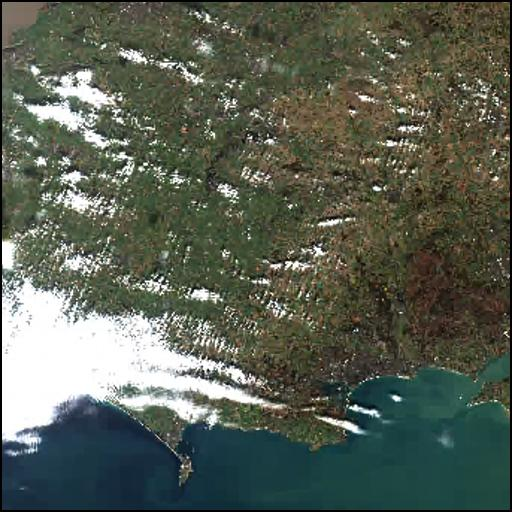

In [31]:
results = next(iter(products)) # gets the second item from the dict
products[results] # show the metadata for the second item

qlook = api.download_quicklook(results) # download the quicklook image for this first result 
display.Image(qlook['path']) # display the image 

In [32]:
product_geo = SentinelAPI.to_geodataframe(products) # convert the search results to a geodataframe
product_geo.head() # show the first 5 rows of the geodataframe

    # calculate the % overlay of the image and the rectangle for selection
for ind, row in product_geo.iterrows():
    intersection = search_area.intersection(row['geometry']) # find the intersection of the two polygons
    product_geo.loc[ind, 'overlap'] = intersection.area / search_area.area # get the fractional overlap
    
print(product_geo.overlap) # show the fractional overlap for each index


31bf9344-ae76-4456-be92-c5a42473f152    0.911773
b91ec50d-7ae9-4835-9ddf-cb57bea28bea    0.288399
a64756c6-d83d-4a12-8d6f-5a6b7f38c8b7    0.170791
f81b20c5-f65c-49e3-ba2b-807afb7976bc    0.867103
f67ba1c1-be68-4b52-8b9a-95a16093f985    0.911773
b86787b2-c62a-4ca7-b41e-87e769916f2b    0.288396
5e029002-305d-4145-8de5-d9b28c40239e    0.187482
97e14348-248e-449e-af71-efb7b81a2fc6    0.877443
30d0e374-ea31-44ed-a3bf-e07bcd649bfc    0.288396
60c02314-1a9a-4d0c-9e60-6173d232b01a    0.190676
Name: overlap, dtype: float64


In [33]:
max_index = product_geo.overlap.argmax() # get the integer location of the largest overlap value
print(max_index) # should be 2

4


In [34]:
best_overlap = product_geo.index[max_index] # get the actual index (image name) with the largest overlap
print(product_geo.loc[best_overlap]) # show the metadata for the image with the largest overlap

title                          S2A_MSIL2A_20230121T111351_N0509_R137_T30UWB_2...
link                           https://scihub.copernicus.eu/dhus/odata/v1/Pro...
link_alternative               https://scihub.copernicus.eu/dhus/odata/v1/Pro...
link_icon                      https://scihub.copernicus.eu/dhus/odata/v1/Pro...
summary                        Date: 2023-01-21T11:13:51.024Z, Instrument: MS...
ondemand                                                                   false
generationdate                                               2023-01-21 14:45:53
beginposition                                         2023-01-21 11:13:51.024000
endposition                                           2023-01-21 11:13:51.024000
ingestiondate                                         2023-01-21 16:33:46.780000
orbitnumber                                                                39602
relativeorbitnumber                                                          137
illuminationazimuthangle    

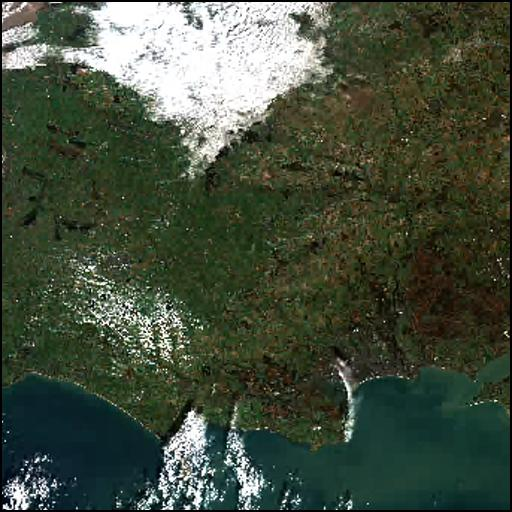

In [35]:
qlook = api.download_quicklook(best_overlap) # download the quicklook image for the first result
display.Image(qlook['path']) # display the image

In [36]:
# api.download(best_overlap) # downloads the first result
api.download(best_overlap, # downloads the first result
             nodefilter=make_path_filter("*_B*.jp2")) # only download the image bands (optional)

SHA3_256 checksumming:   0%|          | 0.00/121M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/120M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/118M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/129M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/33.1M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/32.9M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/32.6M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/32.6M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/33.0M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/32.0M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/33.2M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.76M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/66.7k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/56.7k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/56.7k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/56.7k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

SHA3_256 checksumming:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

{'id': 'f67ba1c1-be68-4b52-8b9a-95a16093f985',
 'title': 'S2A_MSIL2A_20230121T111351_N0509_R137_T30UWB_20230121T144553',
 'size': 1143050813,
 'md5': '44ae9be056e3cc01e774b4315a971165',
 'date': datetime.datetime(2023, 1, 21, 11, 13, 51, 24000),
 'footprint': 'POLYGON((-3.0002747 51.45118220579359,-1.4204712 51.44054116582309,-1.4535522 50.453523278919015,-3.0002747 50.46379840175528,-3.0002747 51.45118220579359))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('f67ba1c1-be68-4b52-8b9a-95a16093f985')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2023, 1, 21, 16, 34, 4, 389000),
 'Ingestion Date': datetime.datetime(2023, 1, 21, 16, 33, 46, 780000),
 'manifest_name': 'manifest.safe',
 'product_root_dir': 'S2A_MSIL2A_20230121T111351_N0509_R137_T30UWB_20230121T144553.SAFE',
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('f67ba1c1-be68-4b52-8b9a-95a16093f985')/Products('Quicklook')/$value",
 'node_path': './S2A_MSIL2A_20230121T111351_N0